In [199]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import deepchem as dc
from tqdm import tqdm_notebook
from scipy.spatial.distance import norm

from fastai.tabular import *
from fastai.callbacks import SaveModelCallback
from fastai.basic_data import DataBunch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [200]:
TYPES              = np.array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'])
TYPES_MAP          = {t: i for i, t in enumerate(TYPES)}
N_EDGE_FEATURES    = 8
N_SC_EDGE_FEATURES = 9
N_ATOM_FEATURES    = 21
MAX_N_ATOMS        = 29
MAX_N_BONDS        = 58
N_TYPES            = len(TYPES)
N_MOLS             = 130775

In [201]:
PATH = '../tmp/'
# PATH = '../storage/CHAMPS/'

In [202]:
files = os.listdir(PATH)
files = [f for f in files if f.find('.csv') != -1]
files

['atomic_features.csv',
 'train_proc_df.csv',
 'mask.csv',
 'edge_mask.csv',
 'pairs_idx.csv',
 'edge_features.csv',
 'test_proc_df.csv']

## Import Data

In [203]:
train_df = pd.read_csv(PATH+'train_proc_df.csv', index_col=0)
test_df  = pd.read_csv(PATH+'test_proc_df.csv', index_col=0)
target = train_df.pop('scalar_coupling_constant')

/anaconda2/envs/python36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [204]:
atomic_features = np.genfromtxt(PATH+'atomic_features.csv', delimiter=',', dtype=np.float64)
edge_features   = np.genfromtxt(PATH+'edge_features.csv', delimiter=',', dtype=np.float64)
pairs_idx       = np.genfromtxt(PATH+'pairs_idx.csv', delimiter=',', dtype=np.int16)
mask            = np.genfromtxt(PATH+'mask.csv', delimiter=',', dtype=np.int16)
edge_mask       = np.genfromtxt(PATH+'edge_mask.csv', delimiter=',', dtype=np.int16)

In [205]:
atomic_features = atomic_features.reshape(N_MOLS, MAX_N_ATOMS, N_ATOM_FEATURES)
edge_features   = edge_features.reshape(N_MOLS, MAX_N_BONDS, N_EDGE_FEATURES)
pairs_idx       = pairs_idx.reshape(N_MOLS, MAX_N_BONDS, 2)
mask            = mask.reshape(N_MOLS, MAX_N_ATOMS)
edge_mask       = edge_mask.reshape(N_MOLS, MAX_N_BONDS)

## Define MPNN Model

In [206]:
def selu_weights_init(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size(1)
        m.weight.data.normal_(0.0, 1.0 / math.sqrt(fan_in))

def hidden_layer(n_in, n_out, batch_norm, dropout, act=None):
    layers = []
    layers.append(nn.Linear(n_in, n_out))
    if act: layers.append(act)
    if batch_norm: layers.append(nn.BatchNorm1d(n_out))
    if dropout != 0: layers.append(nn.Dropout(dropout))
    return layers

class FullyConnectedNet(nn.Module):
    
    def __init__(self, n_input, n_output, layers=[], act=nn.ReLU(True), dropout=[], batch_norm=False, 
                 out_act=None):
        super().__init__()
        sizes = [n_input] + layers + [n_output]
        layers_ = []
        for i, (n_in, n_out, dr) in enumerate(zip(sizes[:-1], sizes[1:], dropout+[0.0])):
            act_ = act if i < len(layers) else out_act
            batch_norm_ = batch_norm if i < len(layers) else False
            layers_ += hidden_layer(n_in, n_out, batch_norm_, dr, act_)      
        self.layers = nn.Sequential(*layers_)
        if type(act) == nn.SELU: self.layers.apply(selu_weights_init)
        
        
    def forward(self, x):
        return self.layers(x)

In [207]:
class HiddenLSTMCell(nn.Module):
    """Implements the LSTM cell update described in the sec 4.2 of https://arxiv.org/pdf/1511.06391.pdf."""
    
    def __init__(self, n_h_out):
        """This LSTM cell takes no external 'x' inputs, but has a hidden state appended with the 
        readout from a content based attention mechanism. Therefore the hidden state is of a dimension
        that is two times the number of nodes in the set."""
        super().__init__()
        self.n_h_out, self.n_h = n_h_out, n_h_out * 2 
        self.w_h = nn.Parameter(torch.Tensor(self.n_h, n_h_out * 4))
        self.b = nn.Parameter(torch.Tensor(n_h_out * 4))
        self.init_weights()
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else: 
                nn.init.zeros_(p.data)
                # initialize the forget gate bias to 1
                p.data[self.n_h_out:self.n_h_out*2] = torch.ones(self.n_h_out)
        
    def forward(self, h_prev, c_prev):
        """Takes previuos hidden and cell states as arguments and performs a single LSTM step using 
        no external input.
        """
        n_h_ = self.n_h_out # number of output hidden states
        # batch the computations into a single matrix multiplication
        gates = h_prev @ self.w_h + self.b
        i_g, f_g, g, o_g = (
            torch.sigmoid(gates[:, :n_h_]), # input
            torch.sigmoid(gates[:, n_h_:n_h_*2]), # forget
            torch.tanh(gates[:, n_h_*2:n_h_*3]),
            torch.sigmoid(gates[:, n_h_*3:]), # output
        )
        c = f_g * c_prev + i_g * g
        h = o_g * torch.tanh(c)
        return h, c

In [208]:
class Set2Set(nn.Module):
    """
    Adapted from: https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric\
        /nn/glob/set2set.html#Set2Set
    """
    def __init__(self, in_channels, proc_steps):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = 2 * in_channels
        self.proc_steps = proc_steps
        self.lstm = HiddenLSTMCell(self.in_channels)

    def forward(self, x, mask):
        """
        x - input tensor of shape (batch_size, n_nodes, in_channels)
        mask - integer tensor used to zero out nodes missing in a particualr graph 
            (not all graphs have 'n_nodes'). Is of shape (batch_size, n_nodes)
        """
        batch_size, n_nodes = mask.size(0), mask.size(1)
        batch_idx = torch.arange(0, batch_size).expand(n_nodes, batch_size).transpose(0, 1)
        h = torch.zeros(batch_size, self.in_channels, device=x.device)
        q_star = torch.zeros(batch_size, self.out_channels, device=x.device
                            )
        mask = (mask.float() - 1) * 1e6
        for i in range(self.proc_steps):
            q, h = self.lstm(q_star, h)
            e = (x * q[batch_idx]).sum(dim=-1)
            # set masked nodes not to large negative energy (attention mask will convert this to 0)
            e += mask 
            a = F.softmax(e, dim=-1)
            # sum a*x over node dimension 
            r = torch.sum(a.unsqueeze(-1) * x, dim=1)
            q_star = torch.cat([q, r], dim=-1)
            
        return q_star
    
    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

In [141]:
def segment_sum(data, segment_ids):
    """
    Computes the sum along segments of a tensor. Analogous to tf.unsorted_segment_sum.

    - data: A tensor whose segments are to be summed.
    - segment_ids: The segment indices tensor.
    - return: A tensor of same data type as the data argument.
    """
    assert all([i in data.shape for i in segment_ids.shape]), "segment_ids.shape should be a prefix of data.shape"
        
    # segment_ids is a 1-D tensor repeat it to have the same shape as data
    if len(segment_ids.shape) == 1:
        s = torch.prod(torch.tensor(data.shape[1:], device=data.device)).long()
        segment_ids = segment_ids.repeat_interleave(s).view(segment_ids.shape[0], *data.shape[1:])

    assert data.shape == segment_ids.shape, "data.shape and segment_ids.shape should be equal"

    num_segments = segment_ids.max() + 1
    shape = [num_segments] + list(data.shape[1:])
    tensor = torch.zeros(*shape, device=data.device).scatter_add(0, segment_ids, data.float())
    tensor = tensor.type(data.dtype)
    return tensor

def segment_mean(data, segment_ids):
    """
    Computes the mean along segments of a tensor. 

    - data: A tensor whose segments are to be averaged.
    - segment_ids: The segment indices tensor.
    - return: A tensor of same data type as the data argument.
    """
    sums = segment_sum(data, segment_ids)
    count = segment_sum(torch.ones_like(data), segment_ids)
    return sums / count.clamp(min=1)

class EdgeNetwork(nn.Module):
    def __init__(self, n_h, n_e, n_sc_e, stride=5, net_args={}):
        super().__init__()
        self.n_e, self.n_h, self.stride = n_e, n_h, stride
        self.adj_net = FullyConnectedNet(n_e, n_h*stride, **net_args)
        self.sc_adj_net = FullyConnectedNet(n_sc_e, n_h*stride, **net_args)
        self.b = nn.Parameter(torch.Tensor(n_h)) # bias for the message function
        nn.init.zeros_(self.b)
    
    def forward(self, h, e, sc_e, mask, edge_mask, pairs_idx, sc_pairs_idx, t=0):
        """
        Compute message vector m_t given the previuos hidden state
        h_t-1 and edge features e.
        - h: tensor of hidden states of shape (batch_size, n_nodes, n_h)
        - e: tensor of edge features of shape (batch_size, n_edges, n_e).
        - sc_e: tensor of scalar coupling edge features of shape 
            (batch_size, n_sc_e).
        - mask: tensor used to  zero out nodes missing in a particular 
            graph (not all graphs have 'n_nodes'). Is of shape 
            (batch_size, n_nodes)
        - edge_mask: tensor of shape (batch_size, n_edges) masking non 
            present edges.
        - pairs_idx: tensor of shape (batch_size, n_edges, 2) mapping atom 
            indexes (first column) to the other atom indexes they form a 
            bond with (second column).
        - sc_pairs_idx: tensor of shape (batch_size, 2) containing atom 
            indices of the atoms for which the scalar coupling constant
            needs to be predicted.
        - t: update iteration. 
        """
        batch_size, n_nodes, n_edges = h.size(0), h.size(1), e.size(1)
        
        # compute 'A(e)'
        edge_mask_ = edge_mask.type(torch.uint8)==True
        edge_mask_flat = edge_mask.view(-1).type(torch.uint8)==True
        if t==0: 
            a_vect = self.adj_net(e.view(-1, self.n_e))
            self.a_mat = a_vect[edge_mask_flat].view(-1, self.n_h, self.stride) / (self.stride ** .5)
        
        # do the matrix multiplication 'Ah'
        h_stacked = torch.cat([h[b,ix,:] for b, ix in enumerate(torch.unbind(pairs_idx[:,:,1]))])
        h_stacked = h_stacked[edge_mask_flat]
        h_unfolded = F.pad(h_stacked, 2*(self.stride//2, )).unfold(1, self.stride, 1)
        # ah = (h_stacked.unsqueeze(1) @ self.a_mat).squeeze(1)
        ah = (h_unfolded * self.a_mat).sum(-1)
        
        # Sum up all 'Ah' per node
        n_nodes_per_graph = pairs_idx[:,:,0].max(dim=1).values + 1
        unique_idx = pairs_idx[:,:,0] + (torch.cat([
                                             torch.zeros(1, dtype=torch.long, device=h.device), 
                                             n_nodes_per_graph[:-1].cumsum(dim=0)
                                         ])).unsqueeze(-1).expand(-1, n_edges)
        m_stacked = segment_sum(ah, unique_idx[edge_mask_])
        
        m_per_graph_lst = torch.split(m_stacked, n_nodes_per_graph.tolist())
        m = torch.cat([F.pad(m_, pad=(0, 0, 0, n_nodes - n_nodes_)) 
                       for m_, n_nodes_ in zip(m_per_graph_lst, n_nodes_per_graph)])
        m = m.view(batch_size, n_nodes, self.n_h)
        
        # add virtual edge messages between atoms of the scalar coupling constant
        if t==0: self.a_sc_mat = self.sc_adj_net(sc_e).view(-1, 1, self.n_h, self.stride) / (self.stride ** .5)
        sc_idx = sc_pairs_idx[:, :, None].repeat(1, 1, self.n_h)
        h_sc_unfolded = F.pad(h.gather(1, sc_idx), 2*(self.stride//2, )).unfold(2, self.stride, 1)
        # ah_sc = (h.gather(1, sc_idx) @ self.a_sc_mat).squeeze(1)
        ah_sc = (h_sc_unfolded * self.a_sc_mat).sum(-1)
        m.scatter_add_(1, sc_idx, ah_sc)
        
        # add message bias
        m += self.b
        
        return m

In [142]:
class GRUUpdate(nn.Module):
    def __init__(self, n_h):
        super().__init__()
        self.n_h = n_h
        self.gru = nn.GRUCell(n_h, n_h)
        
    def forward(self, m, h_prev, mask):
        """
        Update hidden state h.
        - h_prev is vector of hidden states of shape (batch_size, n_nodes, n_h)
        - m is vector of messages of shape (batch_size, n_nodes, n_h)
        - mask is used to  zero out nodes missing in a particualr graph (not all graphs 
            have 'n_nodes'). Is of shape (batch_size, n_nodes)
        """
        batch_size, n_nodes = h_prev.size(0), h_prev.size(1)
        h = self.gru(m.view(-1, self.n_h), h_prev.view(-1, self.n_h))
        return h.view(batch_size, n_nodes, self.n_h) * mask.unsqueeze(-1).repeat(1, 1, self.n_h)

In [143]:
class MyCustomHead(nn.Module):
    def __init__(self, n_input, n_output, pre_layers=[], post_layers=[], act=nn.ReLU(True), dropout=[], 
                 batch_norm=False):
        super().__init__()
        sizes, n_pre_layers = [n_input] + pre_layers, len(pre_layers)
        pre_layers_ = []
        for i, (n_in, n_out, dr) in enumerate(zip(sizes[:-1], sizes[1:], dropout[:n_pre_layers])):
            pre_layers_ += hidden_layer(n_in, n_out, batch_norm, dr, act)      
        self.preproc = nn.Sequential(*pre_layers_)
        self.postproc = nn.ModuleList([
            FullyConnectedNet(pre_layers[-1], n_output, post_layers, act, dropout, batch_norm)
            for _ in range(N_TYPES)
        ])
        
    def forward(self, x, i=0):
        x_ = self.preproc(x)
        y = self.postproc[i](x_)
        return y        

In [144]:
class Set2SetOutput(nn.Module):
    def __init__(self, n_x, n_h, proc_steps, net_args):
        super().__init__()
        self.n_h, self.n_x = n_h, n_x
        self.R_proj = nn.Linear(n_h + n_x, n_h)
        self.R_proc = Set2Set(n_h, proc_steps)
        self.R_write = MyCustomHead(2 * n_h, 1, **net_args)
    
    def forward(self, h, x, mask, types=None):
        """
        Update hidden state h.
        - h is vector of hidden states of shape (batch_size, n_nodes, n_h)
        - x is vector of input features of shape (batch_size, n_nodes, n_x)
        - mask is used to  zero out nodes missing in a particualr graph (not all graphs 
            have 'n_nodes'). Is of shape (batch_size, n_nodes)
        """
        batch_size, n_nodes = h.size(0), h.size(1)
        m = self.R_proj(torch.cat([h.view(-1, self.n_h), x.view(-1, self.n_x)], dim=1))
        m_reshaped = m.view(batch_size, n_nodes, self.n_h)
        q = self.R_proc(m_reshaped, mask) 
        if types is not None:
            y = torch.zeros(batch_size, 1, device=x.device)
            for i in range(N_TYPES):
                if torch.any(types == i): y[types == i] = self.R_write(q[types == i], i)
        else:
            y = self.R_write(q)
        return y

In [145]:
class MPNN(nn.Module):
    def __init__(self, n_x, n_h, n_e, n_sc_e, stride=5, update_steps=3, proc_steps=10, preproc_net_args={}, 
                 enn_args={}, R_net_args={}):
        super().__init__()
        self.n_h, self.n_x = n_h, n_x
        self.preproc_net = FullyConnectedNet(n_x, n_h, **preproc_net_args)
        self.M = EdgeNetwork(n_h, n_e, n_sc_e, stride, enn_args)
        self.U = GRUUpdate(n_h)
        self.R = Set2SetOutput(n_x, n_h, proc_steps, R_net_args)
        self.update_steps = update_steps
        
    def forward(self, x, e, sc_e, mask, edge_mask, pairs_idx, sc_pairs_idx, types):
        batch_size, n_nodes = x.size(0), x.size(1)
        h = self.preproc_net(x.view(-1, self.n_x)).view(batch_size, n_nodes, self.n_h)
        for t in range(self.update_steps):
            m = self.M(h, e, sc_e, mask, edge_mask, pairs_idx, sc_pairs_idx, t)
            h = self.U(m, h, mask)
        y = self.R(h, x, mask, types)
        return y

##  Fit MPNN

In [146]:
n_obs = 50000 # len(train_df)
train_idx, val_idx = train_test_split(np.arange(n_obs), test_size=0.25, shuffle=True, random_state=100)
y_train, y_val = target[train_idx].values, target[val_idx].values

In [147]:
ss_target = StandardScaler()
y_train = ss_target.fit_transform(y_train.reshape(-1,1))
y_val = ss_target.transform(y_val.reshape(-1,1))

In [148]:
def one_hot_encode_np(x):
    sz = len(x), len(np.unique(x))
    x_one_hot = np.zeros(sz, dtype=np.long)
    x_one_hot[np.arange(sz[0]), x] = 1
    return x_one_hot
    
class MoleculeDataset(Dataset):
    
    def __init__(self, df, y, x, e, mask, pairs_idx, edge_mask):
        self.n = len(df)
        self.training = y is not None
        self.y = y.astype(np.float32) if self.training else None
        self.x = x.astype(np.float32)
        self.e = e.astype(np.float32)
        self.mask = mask.astype(np.float32)
        self.pairs_idx = pairs_idx.astype(np.long)
        self.edge_mask = edge_mask.astype(np.float32)
        self.mol_ids = df['molecule_id'].values.astype(np.long)
        self.sc_types = df['type'].values.astype(np.long)
        self.sc_e = np.concatenate(
            (df['dist'].values.reshape(-1,1), 
             one_hot_encode_np(self.sc_types)), 
            axis=1
        ).astype(np.float32)
        self.sc_pairs_idx = df[['atom_index_0', 'atom_index_1']].values.astype(np.long)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        m_idx = self.mol_ids[idx]
        x_ = torch.from_numpy(self.x[m_idx])
        sc_pairs_idx_ = torch.from_numpy(self.sc_pairs_idx[idx])
        sc_bool = torch.zeros(x_.size()[:-1])
        sc_bool.scatter_add_(sc_pairs_idx_.dim()-1, sc_pairs_idx_, torch.ones_like(sc_bool))
        xs = (
            torch.cat([x_, sc_bool.unsqueeze(-1)], dim=-1), 
            self.e[m_idx], 
            self.sc_e[idx], 
            self.mask[m_idx], 
            self.edge_mask[m_idx],
            self.pairs_idx[m_idx],
            sc_pairs_idx_,
            self.sc_types[idx]
        )
        if self.training: return xs, self.y[idx]
        else: return xs    

In [149]:
batch_size = 20

In [150]:
train_ds = MoleculeDataset(train_df.iloc[train_idx], y_train, atomic_features, edge_features, 
                           mask, pairs_idx, edge_mask)
val_ds   = MoleculeDataset(train_df.iloc[val_idx], y_val, atomic_features, edge_features, 
                           mask, pairs_idx, edge_mask)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8)
val_dl   = DataLoader(val_ds, batch_size, num_workers=8)
db = DataBunch(train_dl, val_dl)

In [151]:
batch = next(iter(train_dl))

In [152]:
for el in batch[0]: print(el.size())
print(batch[1].size())

torch.Size([20, 29, 22])
torch.Size([20, 58, 8])
torch.Size([20, 9])
torch.Size([20, 29])
torch.Size([20, 58])
torch.Size([20, 58, 2])
torch.Size([20, 2])
torch.Size([20])
torch.Size([20, 1])


In [153]:
def group_mean_log_mae(y_true, y_pred, types):
    y_true, y_pred, types = y_true.cpu().numpy().ravel(), y_pred.cpu().numpy().ravel(), types.cpu().numpy().ravel()
    y_true = ss_target.mean_ + y_true * ss_target.scale_
    y_pred = ss_target.mean_ + y_pred * ss_target.scale_
    maes = pd.Series(y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes).mean()

class GroupMeanLogMAE(Callback):
    _order = -20 #Needs to run before the recorder
    types_cidx = 2

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['group_mean_log_mae'])
    def on_epoch_begin(self, **kwargs): self.input, self.output, self.target = [], [], []
    
    def on_batch_end(self, last_target, last_output, last_input, train, **kwargs):
        if not train:
            self.input.append(last_input[-1])
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if (len(self.input) > 0) and (len(self.output) > 0):
            inputs = torch.cat(self.input)
            preds = torch.cat(self.output)
            target = torch.cat(self.target)
            metric = group_mean_log_mae(preds, target, inputs)
            return add_metrics(last_metrics, [metric])

def set_seed(seed=100):
    # python RNG
    random.seed(seed)

    # pytorch RNGs
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    np.random.seed(seed)

In [154]:
wd, batch_norm, act = 0, False, nn.ReLU(True)
stride, update_steps, proc_steps = 5, 5, 10
n_x, n_h, n_e, n_sc_e = N_ATOM_FEATURES + 1, 100, N_EDGE_FEATURES, N_SC_EDGE_FEATURES
preproc_net_args = dict(layers=[], act=act, dropout=[], batch_norm=batch_norm, out_act=nn.Tanh())
enn_args = dict(layers=3*[n_h], act=act, dropout=3*[0.0], batch_norm=batch_norm)
R_net_args = dict(pre_layers=[1000], post_layers=[500], act=act, dropout=[0.0, 0.0], 
                  batch_norm=batch_norm)

In [155]:
set_seed(100)
model = MPNN(n_x, n_h, n_e, n_sc_e, stride, update_steps, proc_steps, preproc_net_args, enn_args, R_net_args)

In [156]:
print(model)
print(model(*batch[0]))
print(model(*batch[0]).size())

MPNN(
  (preproc_net): FullyConnectedNet(
    (layers): Sequential(
      (0): Linear(in_features=22, out_features=200, bias=True)
      (1): Tanh()
    )
  )
  (M): EdgeNetwork(
    (adj_net): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=8, out_features=200, bias=True)
        (1): ReLU(inplace)
        (2): Linear(in_features=200, out_features=200, bias=True)
        (3): ReLU(inplace)
        (4): Linear(in_features=200, out_features=200, bias=True)
        (5): ReLU(inplace)
        (6): Linear(in_features=200, out_features=1000, bias=True)
      )
    )
    (sc_adj_net): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=9, out_features=200, bias=True)
        (1): ReLU(inplace)
        (2): Linear(in_features=200, out_features=200, bias=True)
        (3): ReLU(inplace)
        (4): Linear(in_features=200, out_features=200, bias=True)
        (5): ReLU(inplace)
        (6): Linear(in_features=200, out_features=1000, bia

In [157]:
learn = Learner(db, model, metrics=[mean_absolute_error], callback_fns=GroupMeanLogMAE, 
                wd=wd, loss_func=root_mean_squared_error)

In [158]:
# learn.lr_find(start_lr=1e-6, end_lr=1.0, num_it=1000, stop_div=True)
# learn.recorder.plot()

In [159]:
learn.fit_one_cycle(10, max_lr=1e-3, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  name='mpnn1')])

epoch,train_loss,valid_loss,mean_absolute_error,group_mean_log_mae,time
0,0.139916,0.125173,0.089617,1.203657,04:02
1,0.112059,0.115615,0.079239,0.930186,04:02
2,0.095951,0.078833,0.055645,0.697066,04:01
3,0.078143,0.068629,0.049938,0.585224,04:02
4,0.060961,0.060575,0.041510,0.395437,04:03
5,0.057979,0.055635,0.038362,0.312439,04:02
6,0.047109,0.047020,0.032853,0.074022,04:03
7,0.043265,0.043160,0.029433,-0.001837,04:03
8,0.039244,0.040567,0.027054,-0.118747,04:02
9,0.037527,0.039486,0.026269,-0.150652,04:02


Better model found at epoch 0 with group_mean_log_mae value: 1.2036565592581385.
Better model found at epoch 1 with group_mean_log_mae value: 0.9301858086403496.
Better model found at epoch 2 with group_mean_log_mae value: 0.6970664563214801.
Better model found at epoch 3 with group_mean_log_mae value: 0.5852240199460421.
Better model found at epoch 4 with group_mean_log_mae value: 0.3954369613578961.
Better model found at epoch 5 with group_mean_log_mae value: 0.3124393258969201.
Better model found at epoch 6 with group_mean_log_mae value: 0.07402151924145162.
Better model found at epoch 7 with group_mean_log_mae value: -0.0018374386920792796.
Better model found at epoch 8 with group_mean_log_mae value: -0.11874702727064307.
Better model found at epoch 9 with group_mean_log_mae value: -0.1506524764285301.


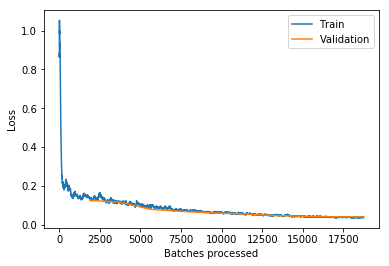

In [160]:
learn.recorder.plot_losses()

In [161]:
learn.fit_one_cycle(10, max_lr=3e-4, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  name='mpnn2')])

epoch,train_loss,valid_loss,mean_absolute_error,group_mean_log_mae,time
0,0.037137,0.039831,0.026716,-0.135224,04:04
1,0.040762,0.040857,0.027813,-0.118756,04:03
2,0.041416,0.043511,0.029447,-0.042085,04:03
3,0.040354,0.042051,0.028564,-0.098809,04:03
4,0.042067,0.039464,0.026063,-0.183661,04:02
5,0.036660,0.039405,0.026558,-0.184131,04:04
6,0.033866,0.037511,0.024469,-0.248594,04:04
7,0.033630,0.037104,0.023868,-0.300470,04:03
8,0.033011,0.036188,0.023089,-0.333698,04:02
9,0.031719,0.036119,0.022954,-0.339710,04:03


Better model found at epoch 0 with group_mean_log_mae value: -0.1352237093990551.
Better model found at epoch 4 with group_mean_log_mae value: -0.18366069053333667.
Better model found at epoch 5 with group_mean_log_mae value: -0.18413106430234247.
Better model found at epoch 6 with group_mean_log_mae value: -0.24859412336539016.
Better model found at epoch 7 with group_mean_log_mae value: -0.30046970518484584.
Better model found at epoch 8 with group_mean_log_mae value: -0.3336982852433294.
Better model found at epoch 9 with group_mean_log_mae value: -0.3397097229538471.


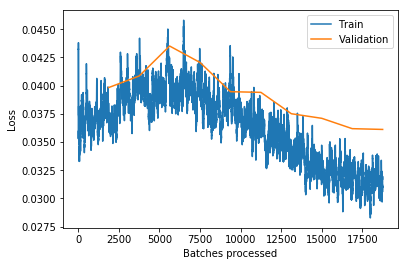

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.fit_one_cycle(10, max_lr=1e-4, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  name='mpnn3')])

epoch,train_loss,valid_loss,mean_absolute_error,group_mean_log_mae,time
0,0.030643,0.036155,0.023116,-0.336306,04:03
1,0.032809,0.036327,0.023226,-0.322680,04:01
2,0.031151,0.036177,0.023066,-0.340673,04:03


Better model found at epoch 0 with group_mean_log_mae value: -0.33630643731369403.
Better model found at epoch 2 with group_mean_log_mae value: -0.34067300246227056.


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.fit_one_cycle(10, max_lr=1e-5, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  name='mpnn4')])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
pred, _ = learn.get_preds()
pred_test, _ = learn.get_preds(DatasetType.Test)